### Generative Adverserial Networks using TensorFlow
GANs are used to create new data given a training set. A generator network and discriminator network try to fool one another in a two-player game. The generator network generates fake data and a discriminator network classifies data which is fake. The generator network tries to fool the discriminator network and the discriminator network learns to NOT get fooled by the generator network. Overtime, both get better and better. We then use the trained generator network to create new images. 
GANs were introduced in the 2014 paper, [Generative Adverserial Nets.](https://arxiv.org/pdf/1406.2661.pdf)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import normalize
from tensorflow.keras import Sequential, layers, losses, optimizers
from tqdm import tqdm
from IPython.display import Image

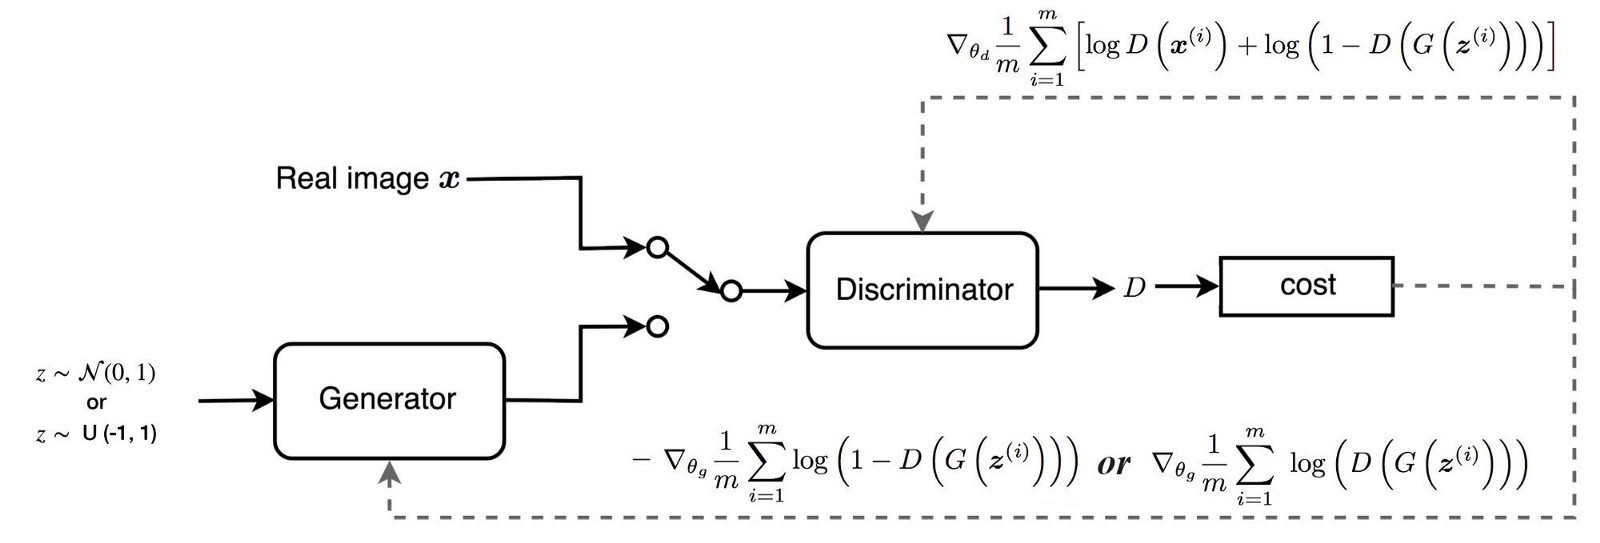

In [2]:
Image(filename=".../gan.jpeg")

### Loss function and optimizer

In [3]:
celoss = losses.BinaryCrossentropy(from_logits=True)
genopt = optimizers.Adam(3e-4) # 3e-4 seems to be a good learning rate for Adam
discopt = optimizers.Adam(3e-4)

In [4]:
epochs, ndim, bsize, bfsize = 50, 100, 250, 60000

### The generator and discriminator networks
The output of the discriminator is going to be single number in the range $[0, 1]$. The output is $D(I)$ where $D$ is the discriminator network and $I$ can either be a real image $x\in dataset$ or a fake image $G(\epsilon)$ where $G$ is the generator network and $\epsilon$ is some noise vector (gaussian prior/noise) we feed in as input to generate images.

In [5]:
def genmodel():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 128)))
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [6]:
def discmodel():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), padding='same', input_shape=[28, 28, 1], kernel_initializer='he_uniform'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

### Generator and discriminator loss
We compute loss using fake labels (vectors of ones and zeros) and compute gradients using tf.GradientTape(). We use cross entropy loss for both networks. For the discriminator, the loss function is $L_d=-\frac{1}{m}\sum_{i=0}^my_ilog(D(I))+(1-y_i)log(1-D(I))$ where $m$ is the batch size and $I$ is either a real image from the training set or a fake image, $G(\epsilon)$. For the generator, the loss function is cross entropy as well, but since all the labels equal to 1, the loss function simplifies to $L_g=\frac{1}{m}\sum_{i=0}^mlog(D(G(\epsilon_i)))$.

In [7]:
def genloss(fakepred):
    return celoss(tf.ones_like(fakepred), fakepred)

In [8]:
def discloss(realpred, fakepred):
    return celoss(tf.ones_like(realpred), realpred) + celoss(tf.zeros_like(fakepred), fakepred)

### Initialize and train model

In [ ]:
Image(filename="C/Users/rgbka/Desktop/gan.png")

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(bfsize).batch(bsize)

In [10]:
generator, discriminator = genmodel(), discmodel()

In [11]:
def step(images):
    noise = tf.random.normal([bsize, ndim])
    with tf.GradientTape() as gentape, tf.GradientTape() as disctape:
        gen = generator(noise, training=True)
        realpred = discriminator(images, training=True)
        fakepred = discriminator(gen, training=True)
        gloss = genloss(fakepred)
        dloss = discloss(realpred, fakepred)
    gengrad = gentape.gradient(gloss, generator.trainable_variables)
    discgrad = disctape.gradient(dloss, discriminator.trainable_variables)
    genopt.apply_gradients(zip(gengrad, generator.trainable_variables))
    discopt.apply_gradients(zip(discgrad, discriminator.trainable_variables))

In [12]:
noises = tf.random.normal([25, 100])
def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        for batch in dataset:
            step(batch)
        genimages = generator(noises, training=False)
        images = [np.reshape(im, (28, 28)) for im in genimages]
        fig = plt.figure(figsize=(10, 10))
        for _ in range(25):
            plt.subplot(5, 5, _ + 1)
            plt.imshow(images[_])
            plt.axis('off')
        plt.savefig(f'mnistgan{epoch}.png')

 40%|██████████████████████████████▊                                              | 20/50 [3:35:42<5:11:13, 622.45s/it]<ipython-input-12-b94c85e392da>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))
100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [8:55:13<00:00, 642.26s/it]


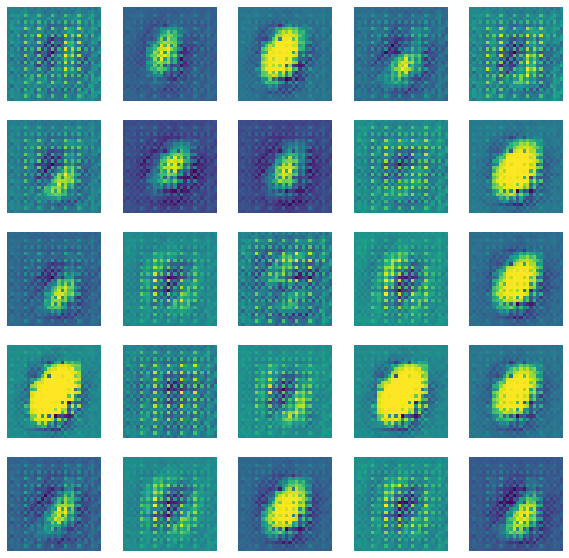

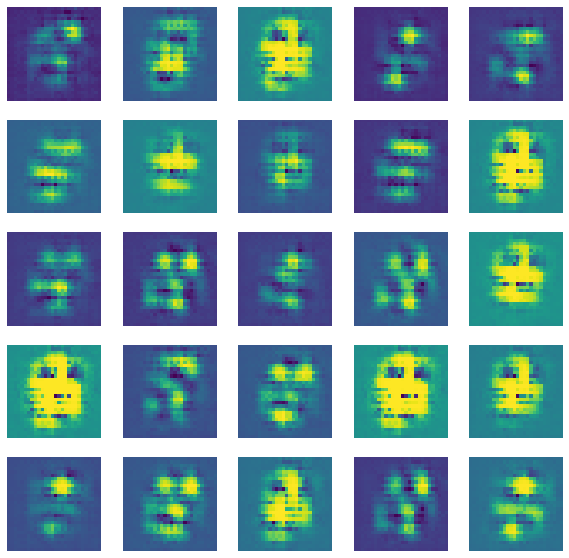

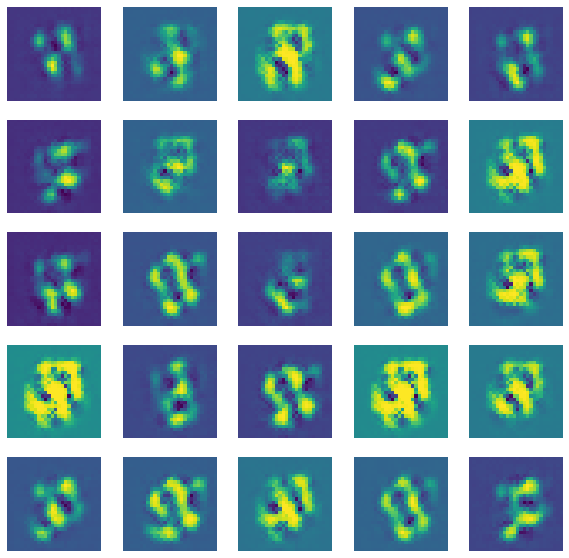

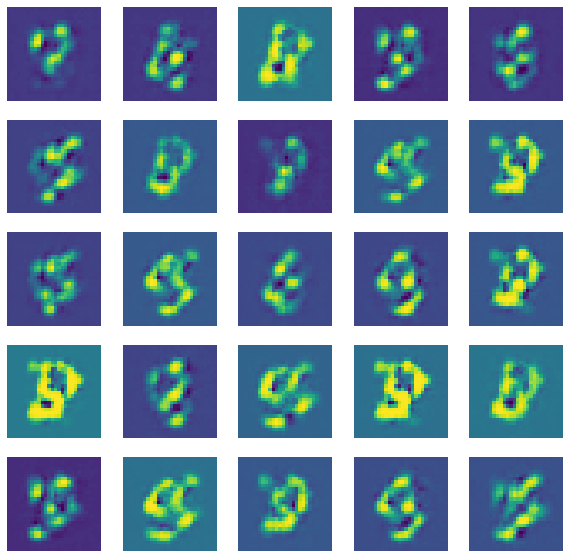

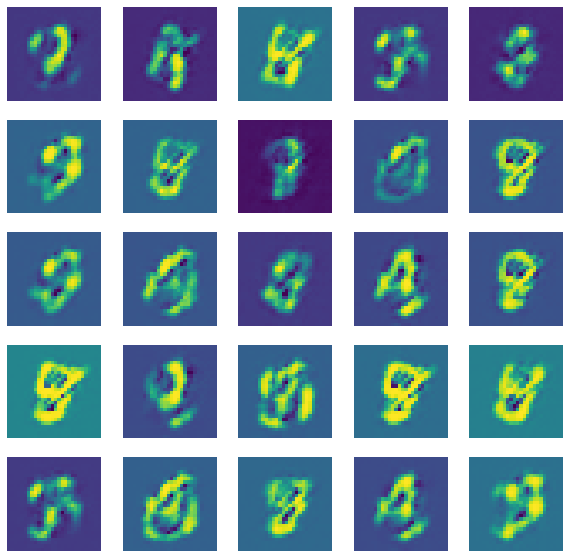

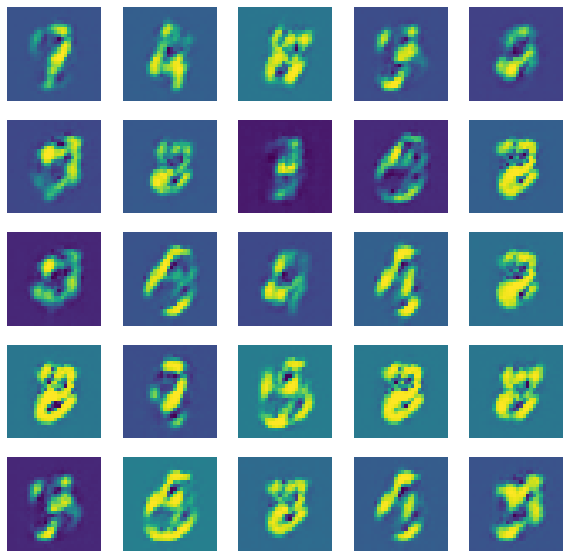

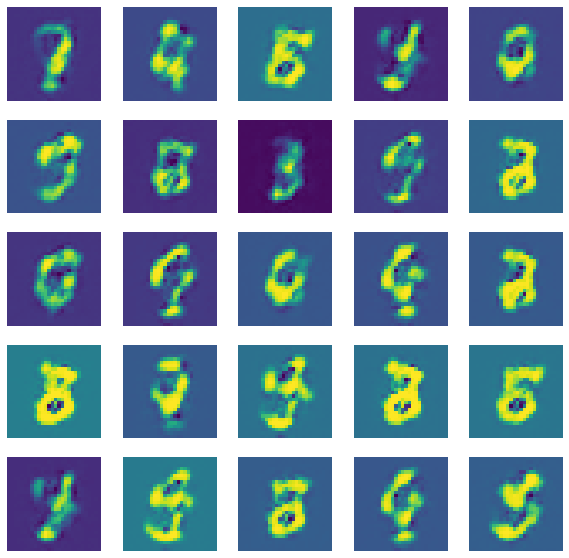

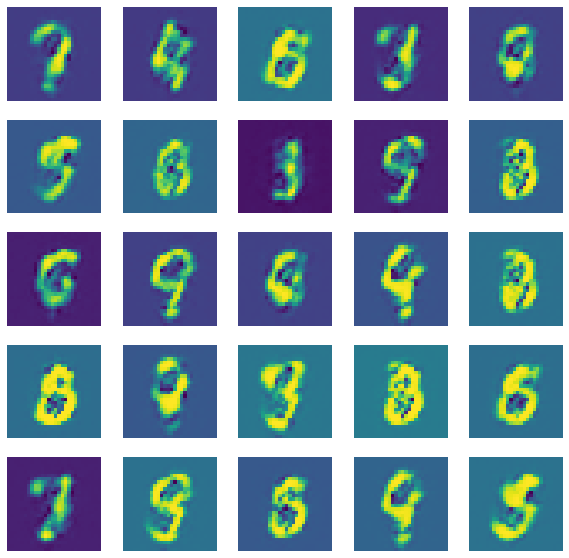

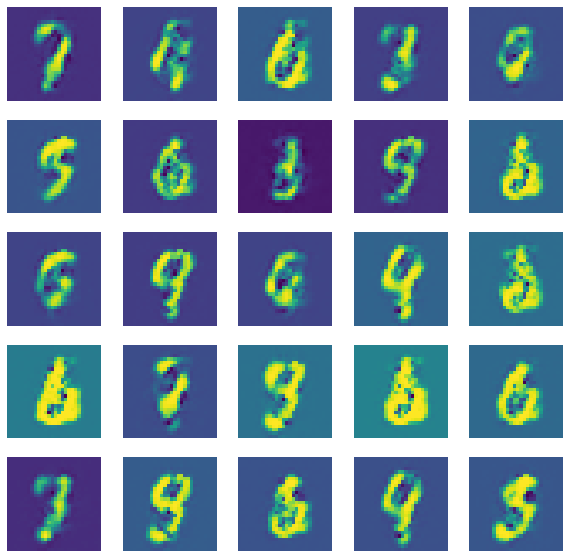

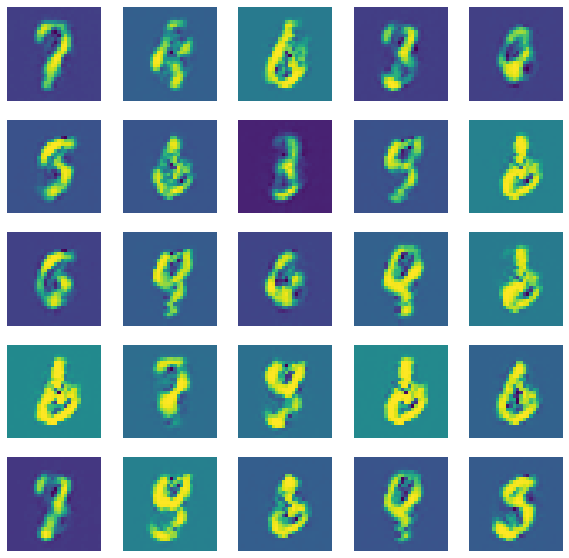

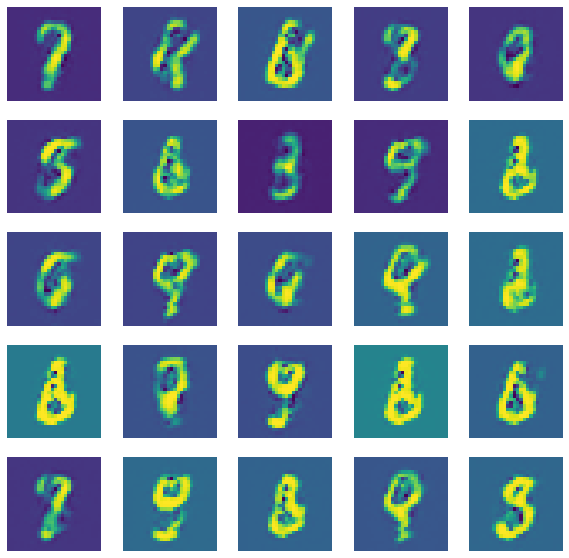

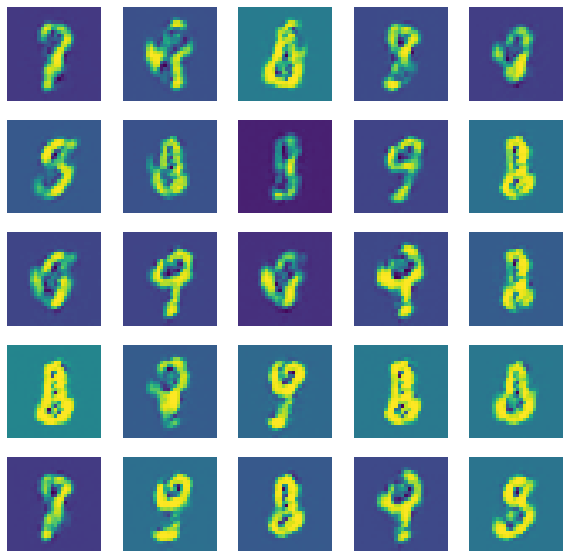

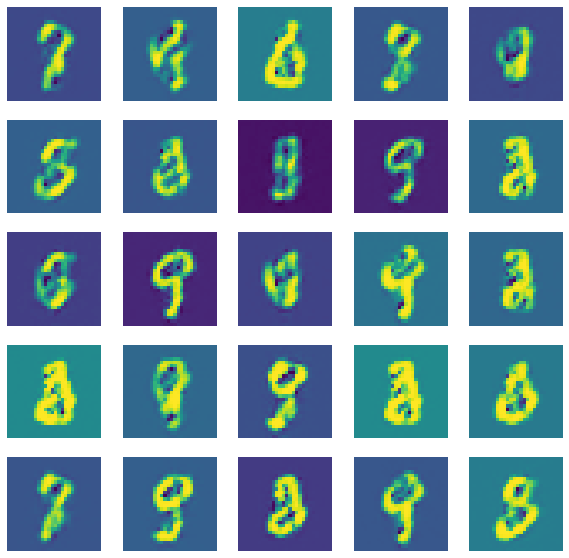

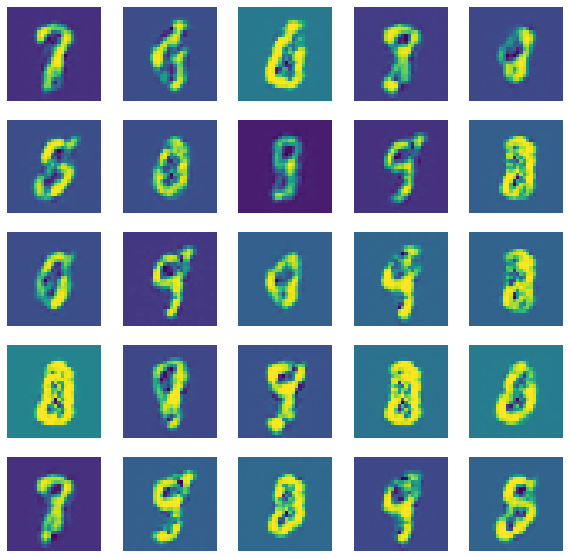

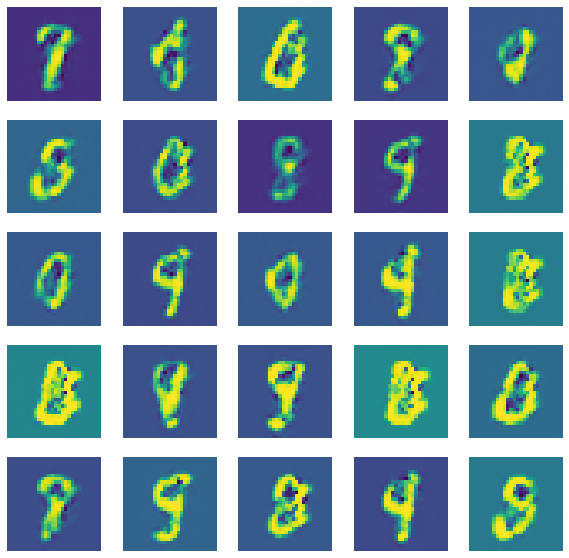

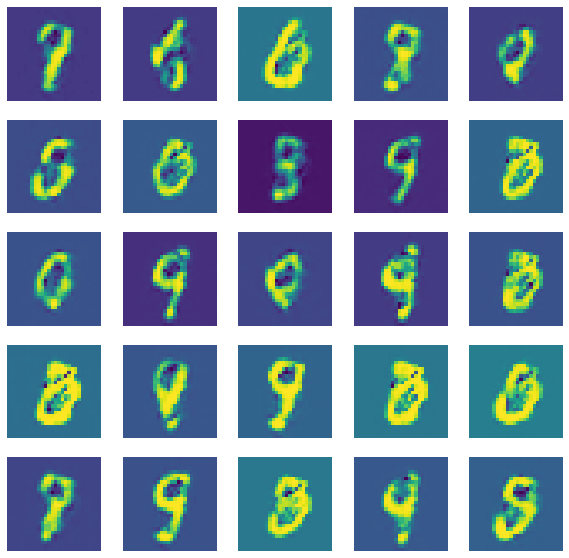

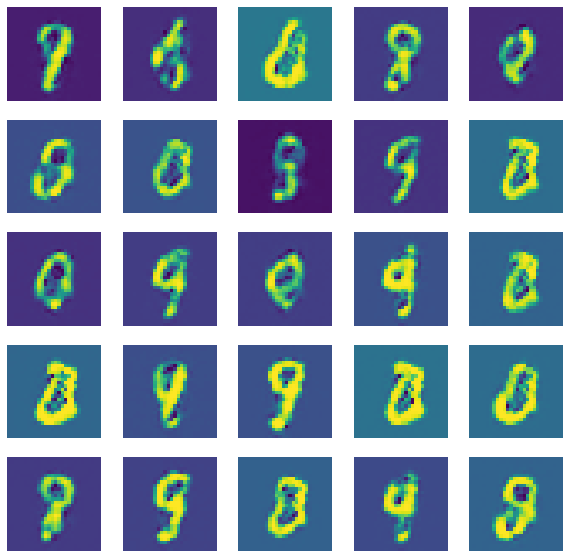

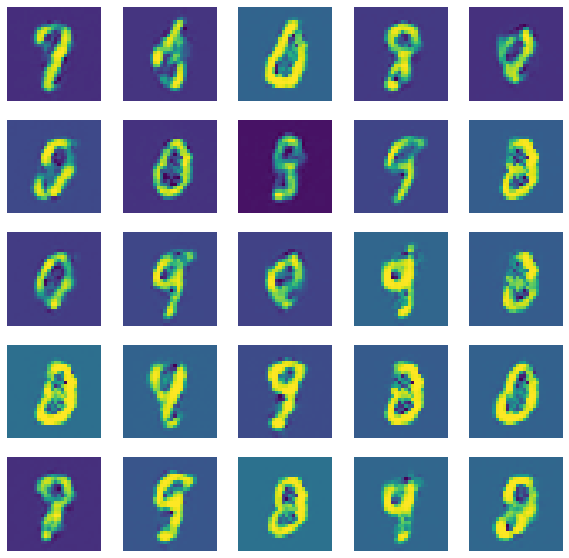

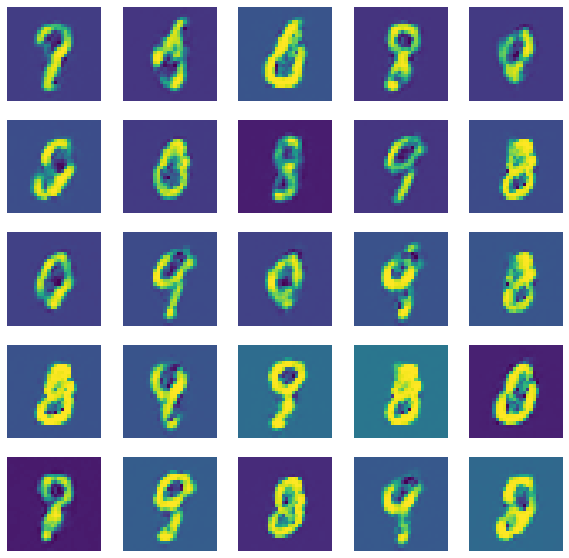

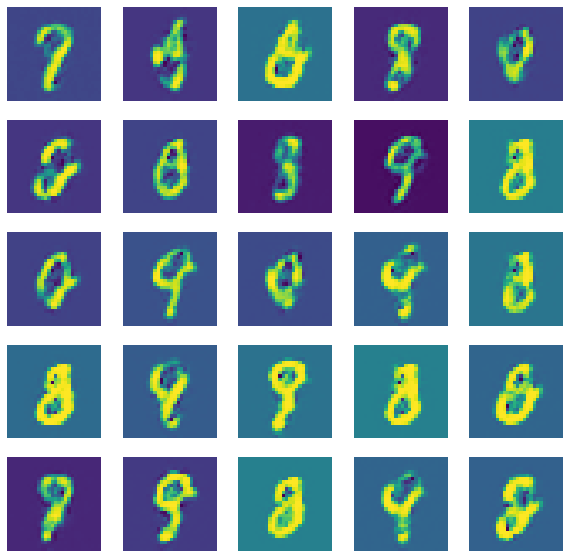

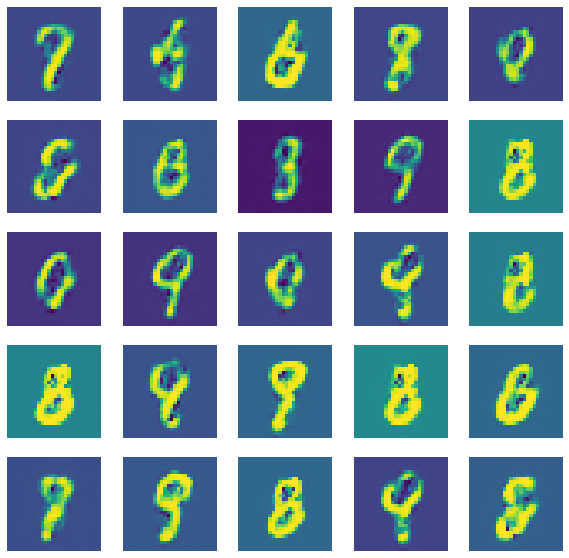

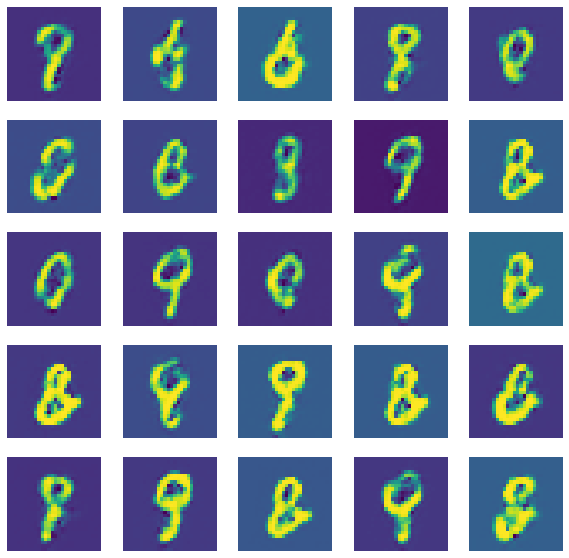

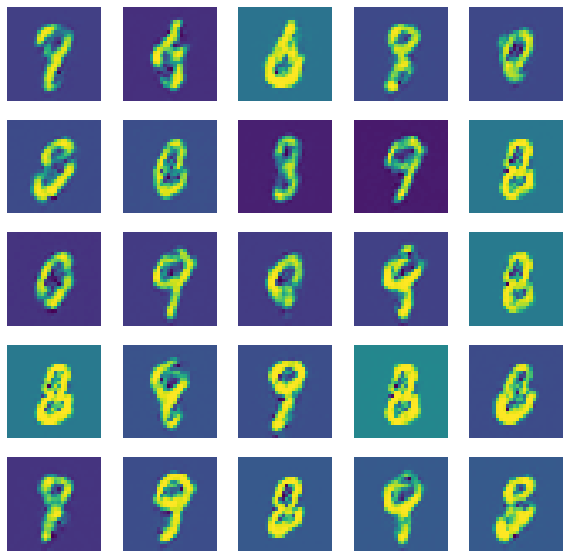

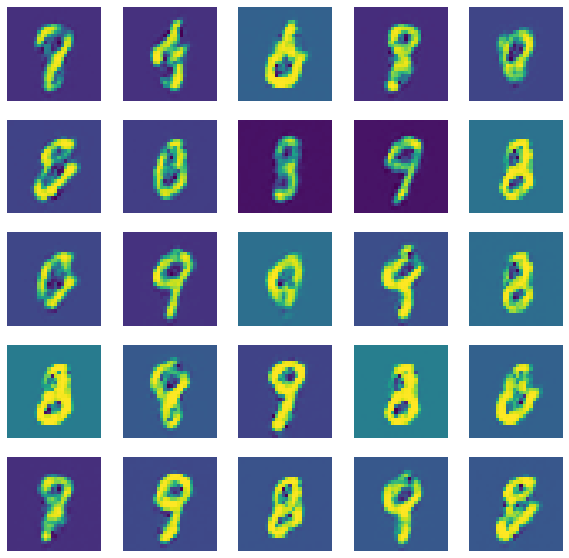

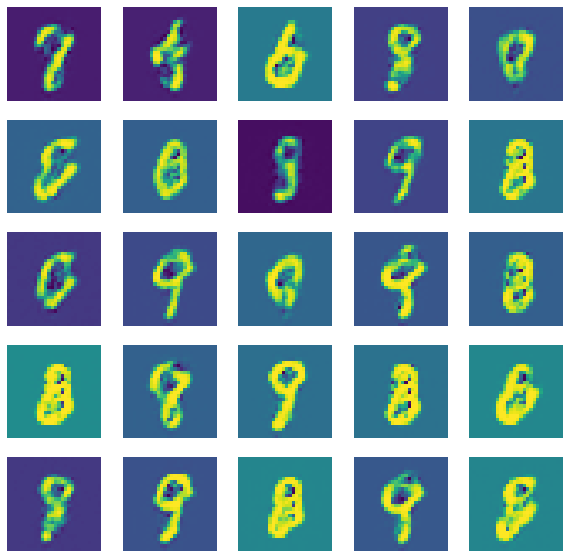

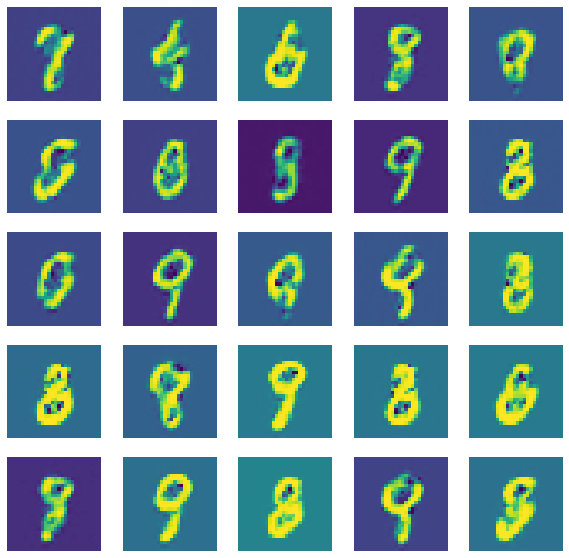

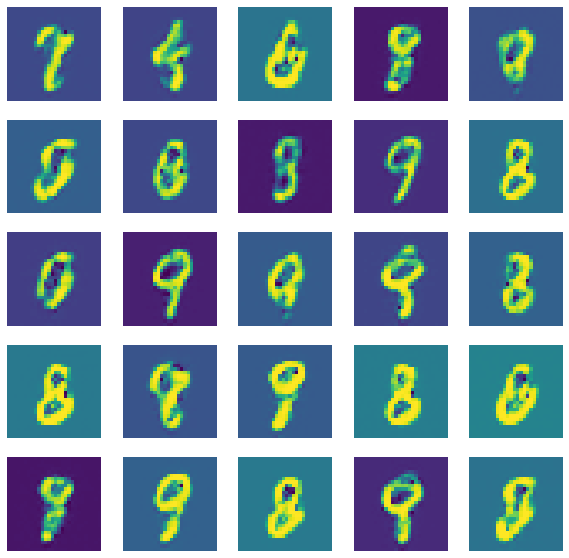

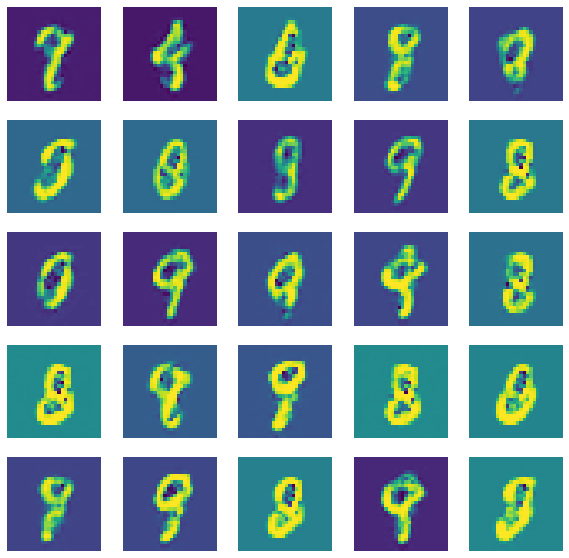

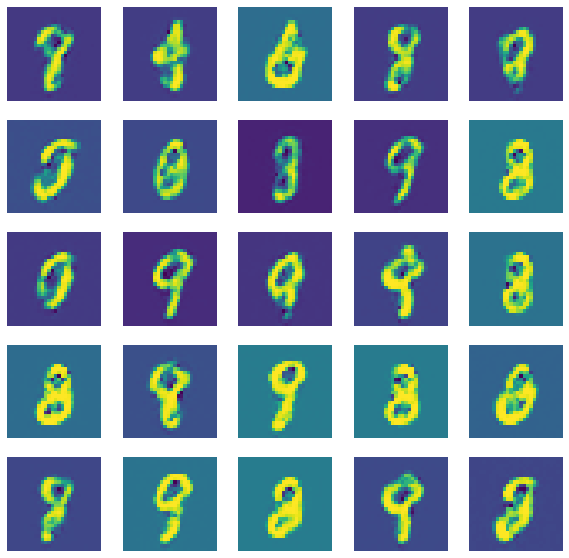

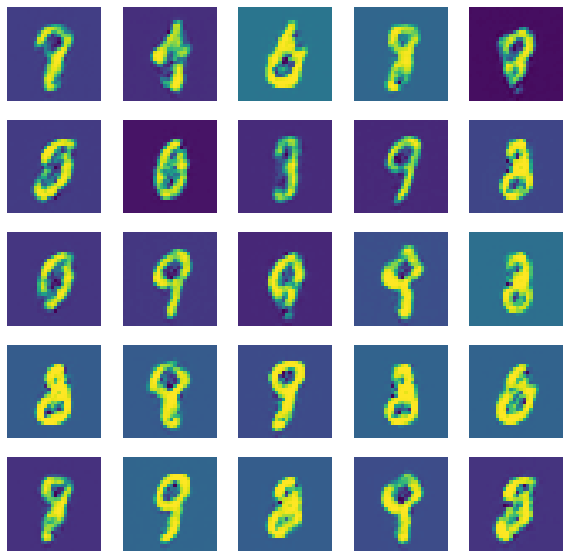

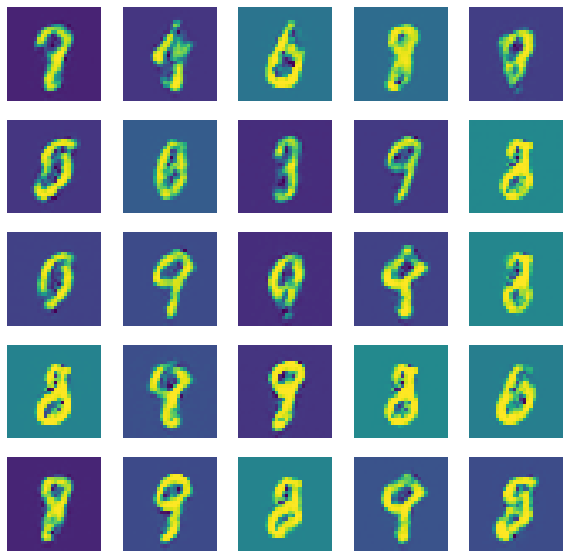

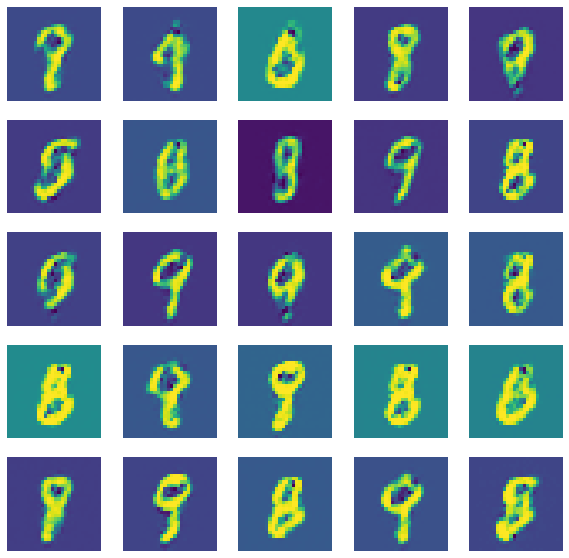

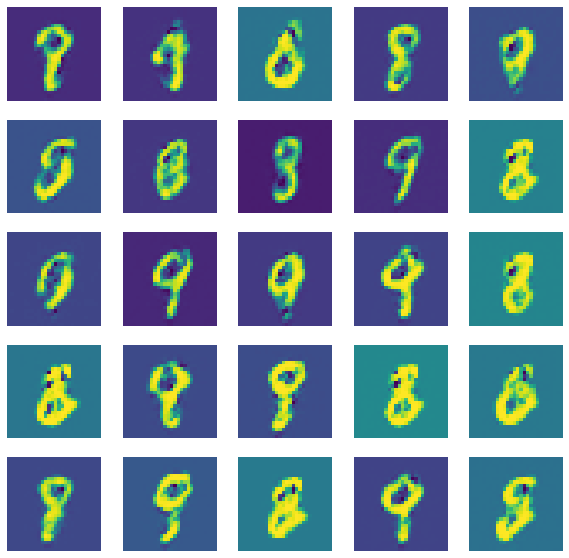

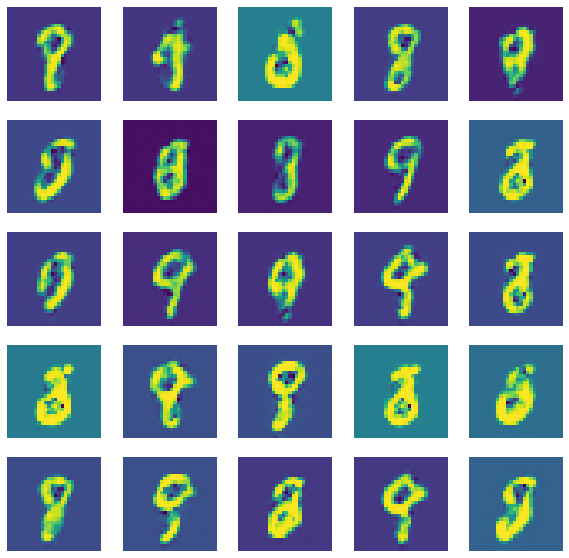

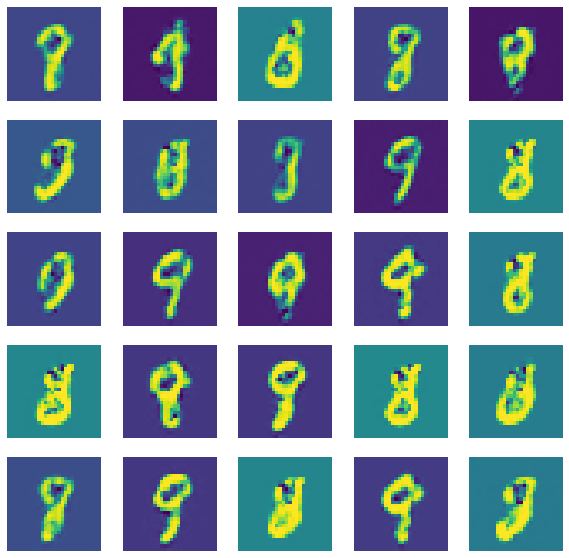

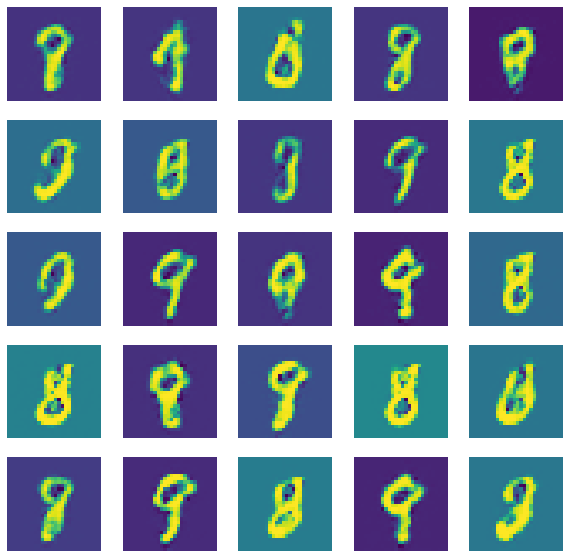

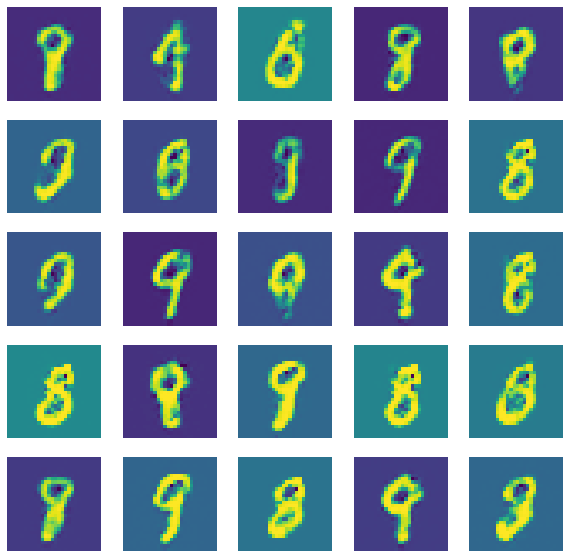

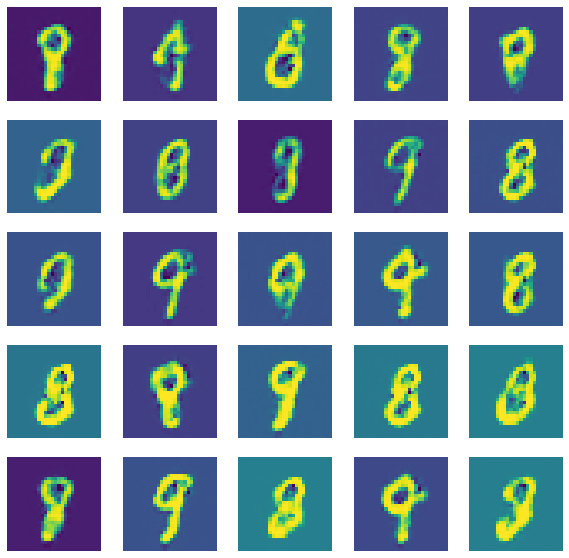

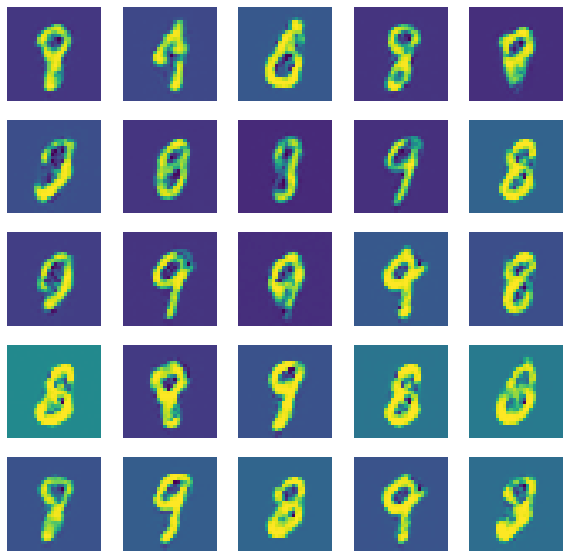

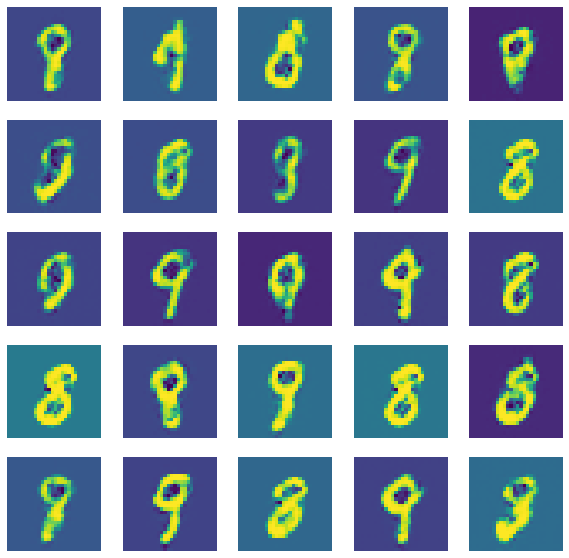

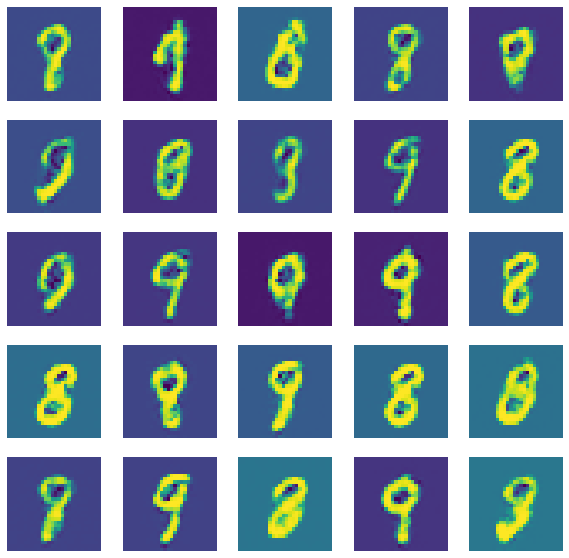

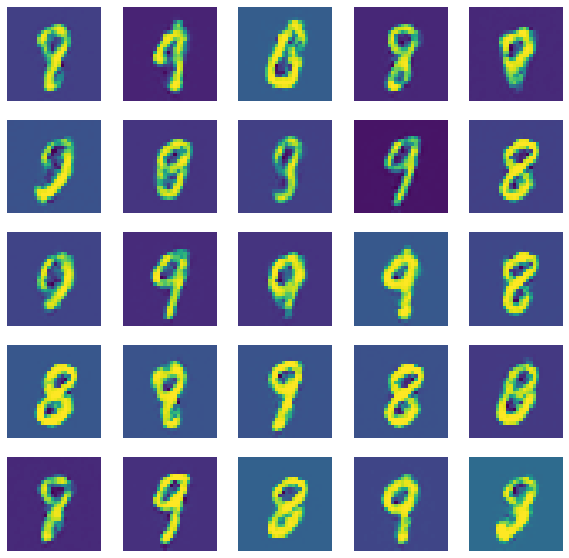

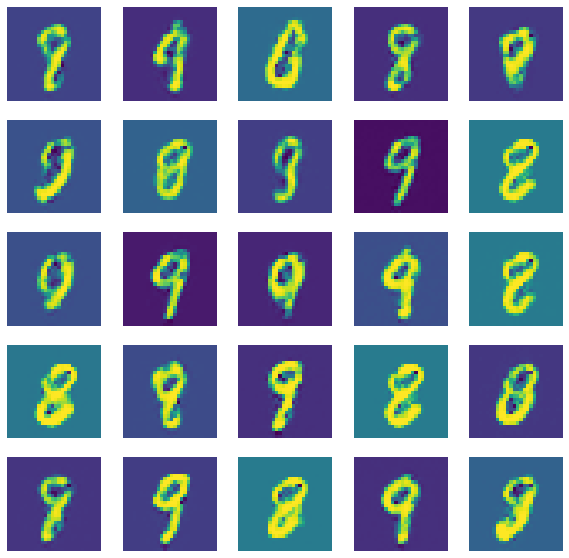

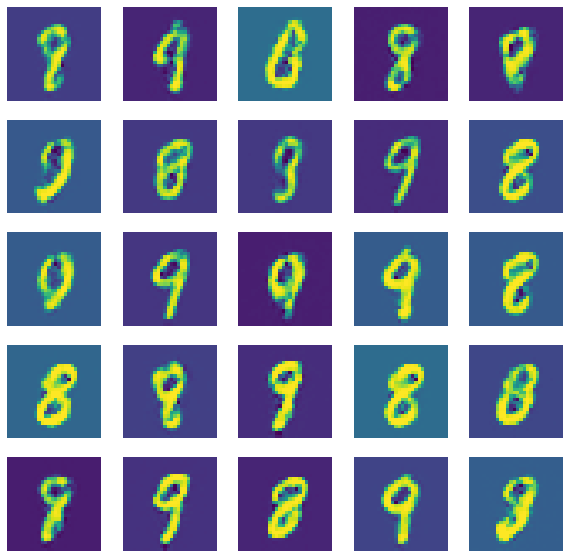

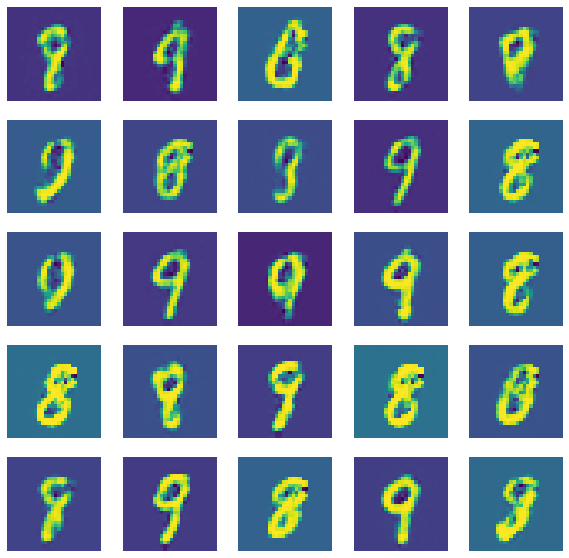

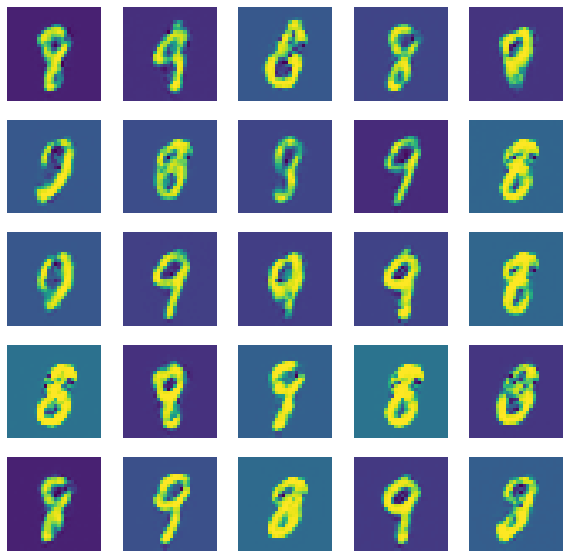

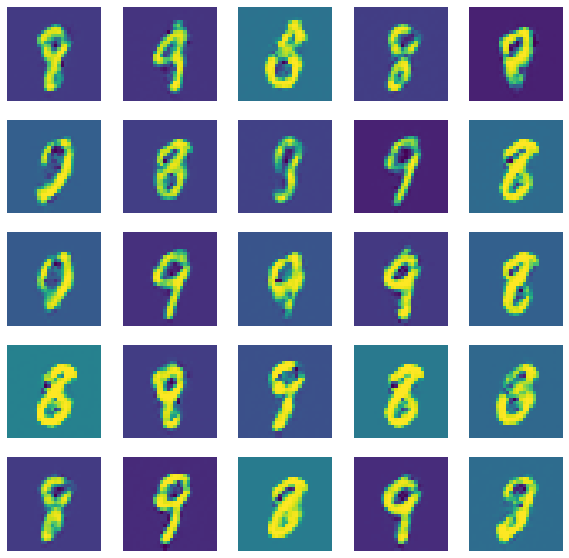

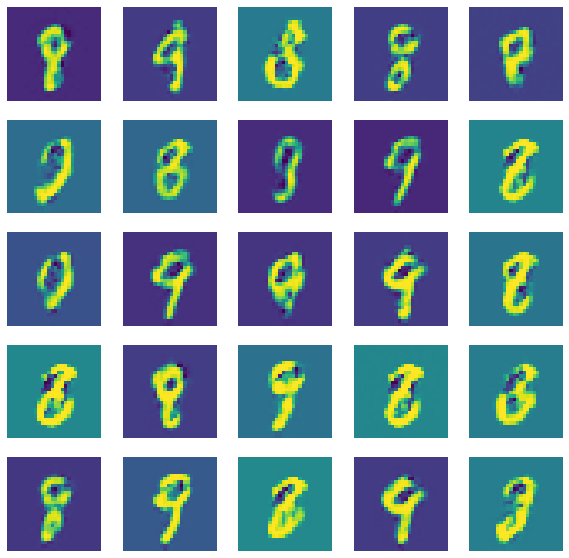

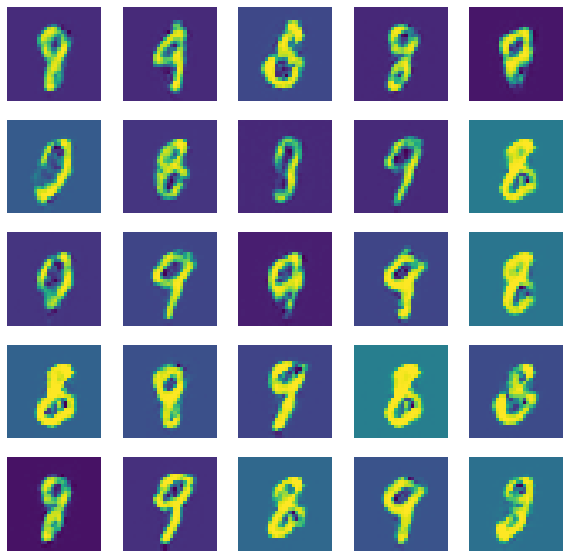

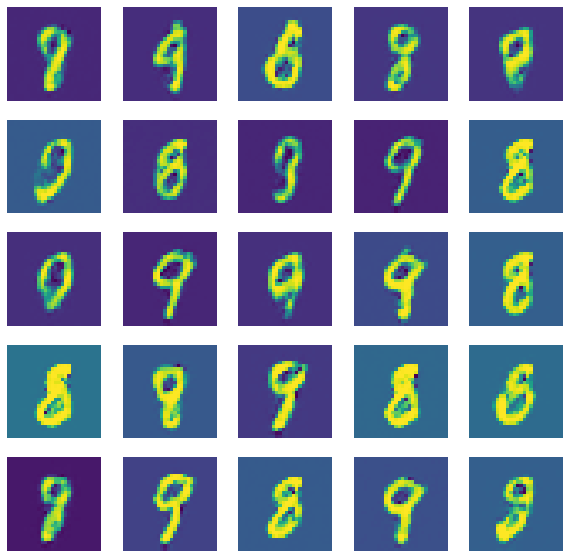

In [13]:
train(dataset, epochs)